<a href="https://www.kaggle.com/code/ksenia5/comparison-of-time-series-forecasting-methods-wip?scriptVersionId=111267088" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Comparison of ML methods of forecasting time series data
**Time series (TS)** data is **univariate or multivariate series** data recorded over time at **regular time intervals**.
<br><br>

**Many process** are **time-dependent**. Capturing patterns in observed data enables **prediction of future processes and events**, useful in planning and operation within many fields.
<br><br>
The project is split across two Kaggle workbooks as outlined below.

### Part 1
1. **Generate synthetic non-stationary time series data via different methods.** <br>
To understand the features of TS data
<br><br>
2. **Characterise datasets and do the required pre-processing.** <br>
Each dataset is characterised via plots and statistical tests, and preprocessing steps are outlined to convert the data to stationary TS, often required for ML forecasting models.
<br><br>

### [Part 2](https://www.kaggle.com/ksenia5/comparison-of-time-series-forecasting-part-2) (separate workbook)
3. **Apply exponential smoothing and the MA/AR/ARMA statistical methods to forecast the test data.** <br>
Exponential smoothing and (S)ARIMA models, the two most common statistical models used for forecasting are compared on synthetic data. 
<br><br>
4. **Apply at least two machine leaning models to forecast the synthetic test data.**
<br><br>
5. **Measure and evaluate the performance of each method/model.** 
<br><br>
6. **[Optional] Find a suitable time series dataset (e.g., sales data, energy demand data, stock prices) and compare the forecasting performances.**

In [1]:
# To generate and manipulate TS data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels as ss
import math

# (S)ARIMA libraries
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import arma_generate_sample # Generate data using ARIMA process
!pip install pmdarima
import pmdarima as pm

# Statistical tests
from scipy.stats.mstats import normaltest
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.stattools as ts # statistical tests including adfuller

# Plotting libraries 
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore')
%precision 3

# System files 
import sys
import os

# Get file paths for reading in real TS data

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

print("set up complete")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 3.7 MB/s eta 0:00:00
set up complete


## 1. Generate synthetic non-stationary time series data
The aim of generating synthetic time series data is to understand this type of data and its common properties.
### Stationary TS data has constant statistical parameters over time, such as a:
* constant mean 
* constant variance 
* no periodic/ seasonal variation
<br><br>
Stationary data can be noise, or what's left after trend and seasonal components have been removed, in which case it is known as the residual.

In [2]:
# Generate N timepoints
N = 300
time = np.arange(1, N+1)

A_r = 20 # amplitute of residual/ noise
np.random.seed(5)  # Set seed for reproducible results
stationary = np.round(np.random.normal(loc=3*A_r, scale=A_r, size=len(time)),decimals = 2)

In [3]:
# Define a plotting function
def ts_plot(x, y, title, xlabel="Time", ylabel="Value",width = 10, height = 6, label = ""):
    plt.figure(figsize=(width, height))
    plt.plot(x, y, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label != "":
        plt.legend(loc='upper left')
    plt.show
    plt.savefig(title)

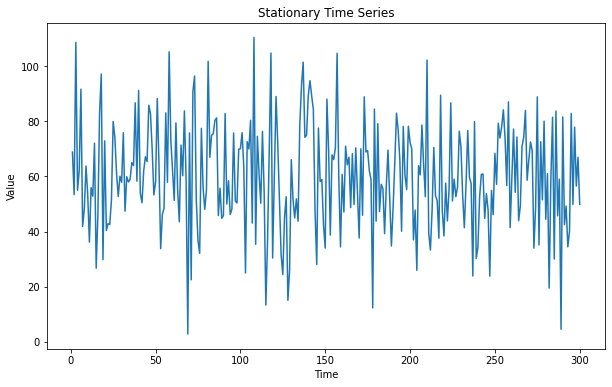

In [4]:
ts_plot(time,stationary,"Stationary Time Series")
 

### Non-stationary TS data has one or more of the following:
* trend (change in mean over time)
* heteroscedasticity (change in variance over time)
* seasonanality/ periodicity - pattern repeating at regular time intervals
* non-constant autocorrelation
<br> <br>

Synthetic non-stationary TS data can be created by combining some of these components through **additive**, **multiplicative** composition.
<br> <br>
#### Trend
Here, a linear trendline with equation *y = mx + c* is given as an example
    

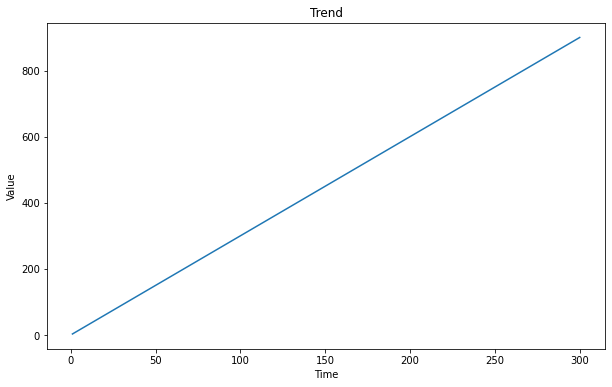

In [5]:
# Trend (linear), y = Mx + C
M,C = (3,0)
trend = time * M + C

ts_plot(time,trend,"Trend")

**Seasonality**
<br><br>
Seasonality or periodicity is a repeating pattern observed over time
<br><br>


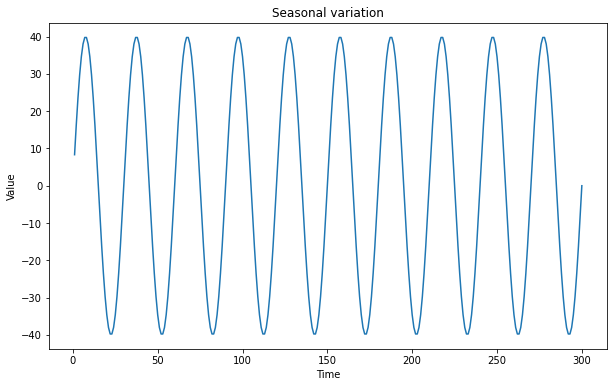

In [6]:
# Seasonal component with amplitude A_s and frequncy freq
A_s = 40
freq = 10
seasonal = np.round(A_s*np.sin(time*freq*2*math.pi/N),decimals = 2)
ts_plot(time, seasonal, "Seasonal variation")

#### Residual
The residual is the **stationary part of the data** (see above), with a constant mean and variance over time.

### Additive composition of time series data

In [7]:
# Additive composition
additive_ts = trend + seasonal
additive_tsr = trend + seasonal + stationary

# Make dataframe with components and composed data
outcome_df = pd.DataFrame({'time':time,'trend':trend,'seasonal':seasonal,'residual':stationary,'trend with seasonal':additive_ts,'outcome':additive_tsr})
outcome_df.head()

,time,trend,seasonal,residual,trend with seasonal,outcome
0,1,3,8.32,68.82,11.32,80.14
1,2,6,16.27,53.38,22.27,75.65
2,3,9,23.51,108.62,32.51,141.13
3,4,12,29.73,54.96,41.73,96.69
4,5,15,34.64,62.19,49.64,111.83


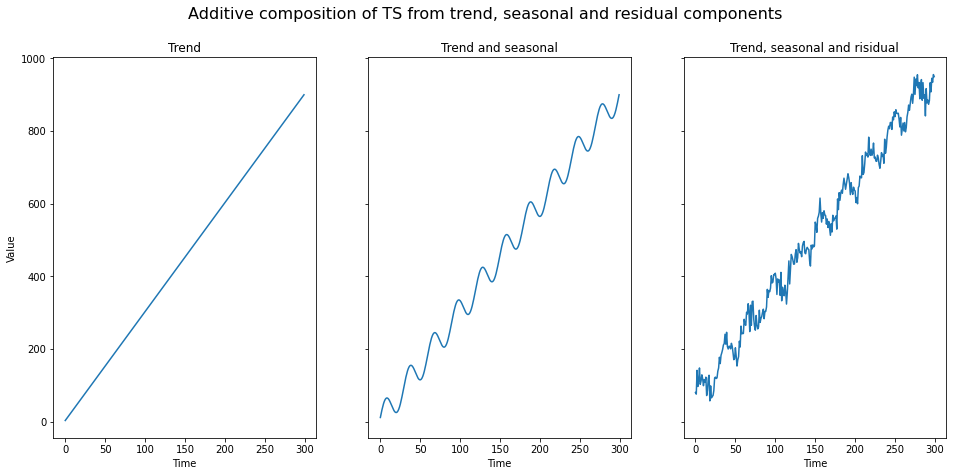

In [8]:
# Plot TS data composed from trend, seasonality and residual
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(16)
axes[0].plot(outcome_df['trend'])
axes[0].set_ylabel("Value")
axes[0].set_xlabel("Time")
axes[0].set_title("Trend")

axes[1].plot(outcome_df['trend with seasonal'])
axes[1].set_xlabel("Time")
axes[1].set_title("Trend and seasonal")

axes[2].plot(outcome_df['outcome'])
axes[2].set_xlabel("Time")
axes[2].set_title("Trend, seasonal and risidual")


fig.suptitle('Additive composition of TS from trend, seasonal and residual components',fontsize = 16)
plt.savefig('Additive composition of TS from trend, seasonal and residual components')

### Multiplicative composition of TS data

To synthesise TS data via multiplicative composition requires scaling the seasonal and residual(stationary) components, so that their magnitude is expressed as a scale factor relative to 1.

In [9]:
# Scaling seasonal variation
seasonal = np.round((100+seasonal)/100,decimals = 3)

# Scaling the residual
A_r = A_r/100 # amplitute of residual/ noise
np.random.seed(42)  # Set seed to get reproducible results
stationary = np.round(np.random.normal(loc=1, scale=A_r, size=len(time)),decimals=3)

# Trend, (trend + seasonality), (trend + seasonality + residual)
# via additive model, superimposed
multiplicative_ts = np.round(trend*seasonal, decimals = 2)
multiplicative_tsr = np.round(trend*seasonal*stationary, decimals = 2)
outcome_m = pd.DataFrame({'time':time,'trend':trend,'seasonal': seasonal ,'residual':stationary, 'trend with seasonal': multiplicative_ts ,'outcome':multiplicative_tsr})
outcome_m.head()

,time,trend,seasonal,residual,trend with seasonal,outcome
0,1,3,1.083,1.099,3.25,3.57
1,2,6,1.163,0.972,6.98,6.78
2,3,9,1.235,1.130,11.12,12.56
3,4,12,1.297,1.305,15.56,20.31
4,5,15,1.346,0.953,20.19,19.24


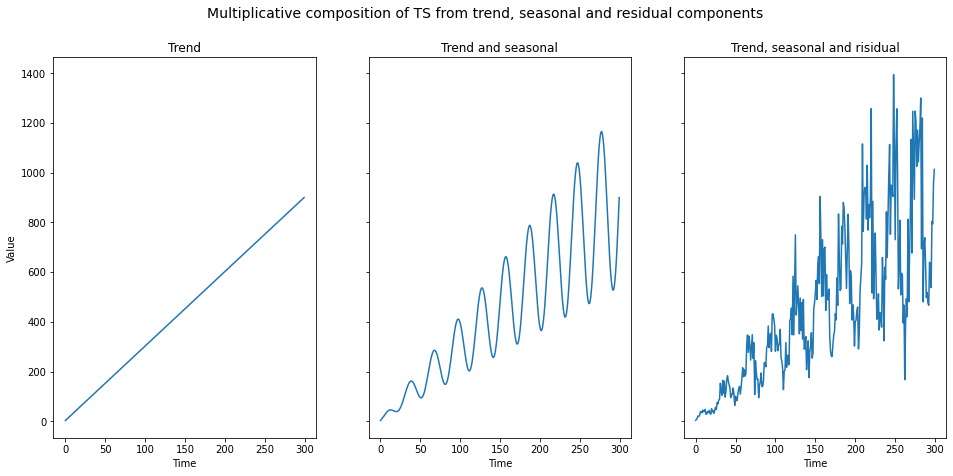

In [10]:
# Plot TS data composed from trend, seasonality and residual
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
fig.set_figheight(7)
fig.set_figwidth(16)
axes[0].plot(outcome_m['trend'])
axes[0].set_ylabel("Value")
axes[0].set_xlabel("Time")
axes[0].set_title("Trend")

axes[1].plot(outcome_m['trend with seasonal'])
axes[1].set_xlabel("Time")
axes[1].set_title("Trend and seasonal")

axes[2].plot(outcome_m['outcome'])
axes[2].set_xlabel("Time")
axes[2].set_title("Trend, seasonal and risidual")


fig.suptitle('Multiplicative composition of TS from trend, seasonal and residual components',fontsize =14)
plt.savefig('Multiplicative composition of TS from trend, seasonal and residual components')

The amplitude of seasonal and residual variation changes as the trend changes

Text(0.5, 0.98, 'Composition of time series data from trend, seasonal and residual components')

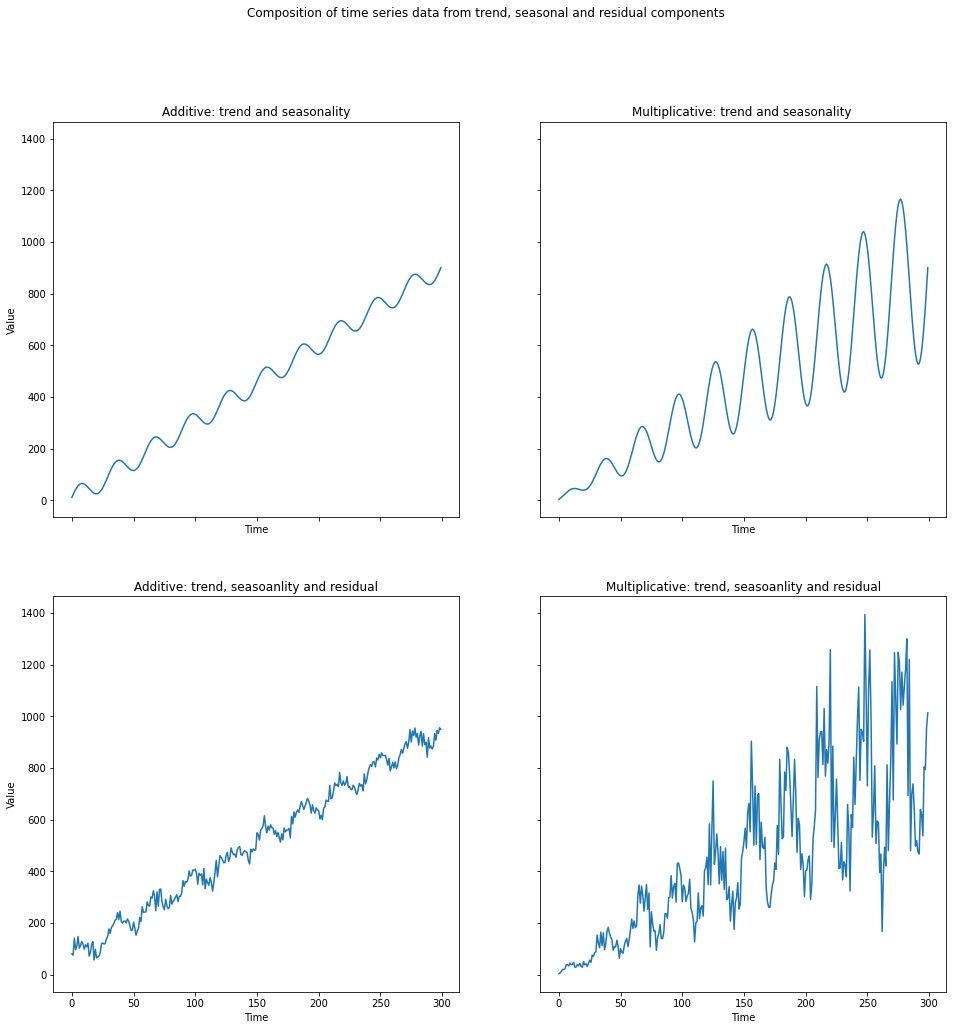

In [11]:
# Plot TS data composed from trend, seasonality and residual
fig, axes = plt.subplots(2,2, sharex=True, sharey=True)
fig.set_figheight(16)
fig.set_figwidth(16)


axes[0,0].plot(outcome_df['trend with seasonal'])
axes[0,0].set_ylabel("Value")
axes[0,0].set_xlabel("Time")
axes[0,0].set_title("Additive: trend and seasonality")

axes[0,1].plot(outcome_m['trend with seasonal'])
axes[0,1].set_xlabel("Time")
axes[0,1].set_title("Multiplicative: trend and seasonality ")

axes[1,0].plot(outcome_df['outcome'])
axes[1,0].set_ylabel("Value")
axes[1,0].set_xlabel("Time")
axes[1,0].set_title("Additive: trend, seasoanlity and residual")

axes[1,1].plot(outcome_m['outcome'])
axes[1,1].set_xlabel("Time")
axes[1,1].set_title("Multiplicative: trend, seasoanlity and residual")

fig.suptitle('Composition of time series data from trend, seasonal and residual components')

### Autocorrelation in TS

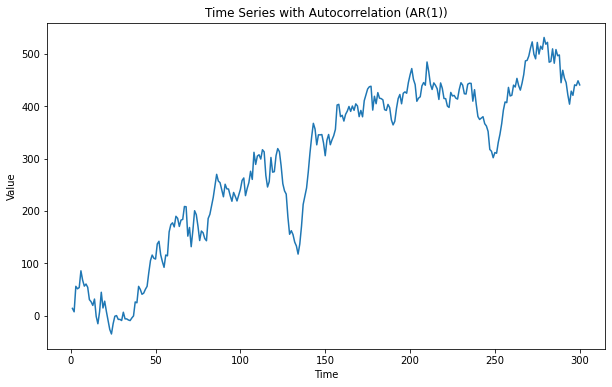

In [12]:
time = np.arange(1,N+1)

# amplitute of stationary (residual) componenet
A_r = 20 
np.random.seed(5)  # Set seed to get reproducible results
stationary = np.round(np.random.normal(loc=0, scale=A_r, size=len(time)),decimals = 2)

# autocorrelation coefficient alpha
alpha = 1.005
seed = 5

# Create empy array to store autocorrelation TS
ac_ts = np.empty(N)

for index, value in enumerate(time):
    value = np.round(alpha*seed + stationary[index],decimals = 2)
    ac_ts[index] = value
    seed = value
ac_ts = ac_ts.astype("double")
# Plot autocorrelation TS
ts_plot(time,ac_ts,"Time Series with Autocorrelation (AR(1))")

#### Heteroscedastic TS data
Has a changing variance over time



In [13]:
A_r = 10 # amplitute of residual/ noise
np.random.seed(5)  # Set seed to get reproducible results
heteroscedastic = np.empty(0)
for i in range(10):
    temp = np.round(np.random.normal(loc=3*A_r, scale=A_r*i, size=int(N/10)),decimals = 2)
    heteroscedastic = np.append(heteroscedastic,temp)
    
#print(len(time))
#len(heteroscedastic)

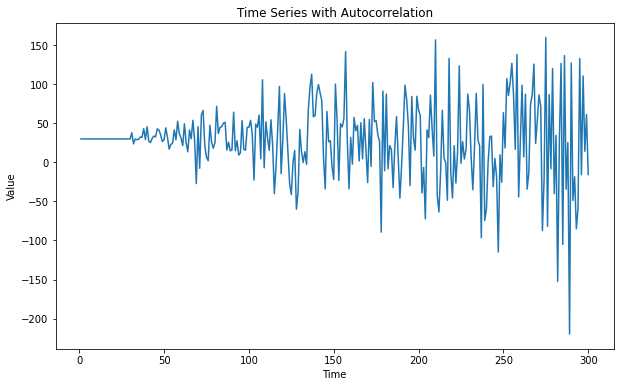

In [14]:
ts_plot(time,heteroscedastic,"Time Series with Autocorrelation")

#### Fourier TS

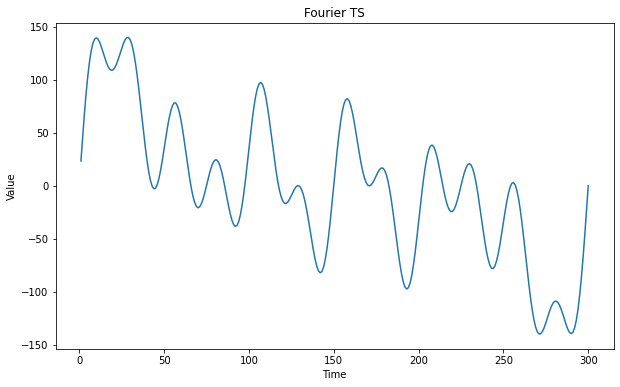

In [15]:
# Seasonal component with amplitude A_s and frequncy freq
np.random.seed(8)  # Set seed to get reproducible results
# N = 300 is the length of time series
A_f = 40 # amplitude
n_components = 5
freqs = np.array([1,2,3,4,6,12])
f_coefficients = np.round(np.random.normal(loc=2*A_f, scale=A_f, size=n_components),decimals = 3)

fourier_ts = np.empty(N)
for freq in freqs:
    component = np.round(A_f*np.sin(time*freq*2*math.pi/N),decimals = 3)
    fourier_ts += component
ts_plot(time, fourier_ts, "Fourier TS")

In [16]:
# Make dataframe with additive, multiplicative and autocorrelation TS
# for subsequent processing
models_df = pd.DataFrame({'time':time,'additive':additive_tsr,'multiplicative': multiplicative_tsr, 'autocorrelation':ac_ts,'heteroscedastic':heteroscedastic,"fourier":fourier_ts})
models_df.head()

# save dataframe to csv for use in ARIMA/ ML
models_df.to_csv('synthetic_ts.csv') 
models_df.head()

,time,additive,multiplicative,autocorrelation,heteroscedastic,fourier
0,1,80.14,3.57,13.84,30.0,23.333
1,2,75.65,6.78,7.29,30.0,45.924
2,3,141.13,12.56,55.95,30.0,67.075
3,4,96.69,20.31,51.19,30.0,86.164
4,5,111.83,19.24,53.64,30.0,102.680


## 2. Characterisation and pre-processing of TS data

Non-stationary data is hard to model and forecast, so such data is processed and transformed to yield stationary data prior to applying prediction algorithms.
<br><br>
The first step is to identify sources of non-stationarity. This can be achieved through:
* simple TS plot, visual identify if mean and variance change over time, and if there is seasonal variation
* summary statistics of data split into chunks across time
* statistical test for stationarity - the augmented Dickey-Fuller test
<br><br>

Once non-stationary elements are identified, data can be processed in one of the following ways:
* exponential smoothing to remove noise and identify trend; the trend is then subtracted from the data
* Loess (STL) method - works well with addtive model
* Frequency-based (spectral) analysis



In [17]:
# Define a plotting function
# to show mean and SD for chunks of data
def ts_plot_msigma(x, y, title, xlabel="Time", ylabel="Value",width = 12, height = 8, nchunks = 10):
    # split data into chunks
    chunks = np.split(y, indices_or_sections=nchunks)
    chunk_mean, chunk_sd_upper, chunk_sd_lower = np.empty(0),np.empty(0),np.empty(0)
    # Fill array with chunk mean and mean+/- SD values for plotting
    for i, chunk in enumerate(chunks):
        mean = np.mean(chunk)
        sd = math.sqrt(np.var(chunk))
        chunk_mean = np.append(chunk_mean, np.full(shape=len(chunk), fill_value=mean, dtype='float'))
        chunk_sd_upper = np.append(chunk_sd_upper, np.full(shape=len(chunk), fill_value=mean + sd, dtype='float'))
        chunk_sd_lower = np.append(chunk_sd_lower, np.full(shape=len(chunk), fill_value=mean-sd, dtype='float'))
            
    # Plot            
    plt.figure(figsize=(width, height))
    plt.plot(x, y)
    plt.plot(x,chunk_mean, color = 'purple')
    plt.plot(x,chunk_sd_upper,'g-.')
    plt.plot(x,chunk_sd_lower, 'g-.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show

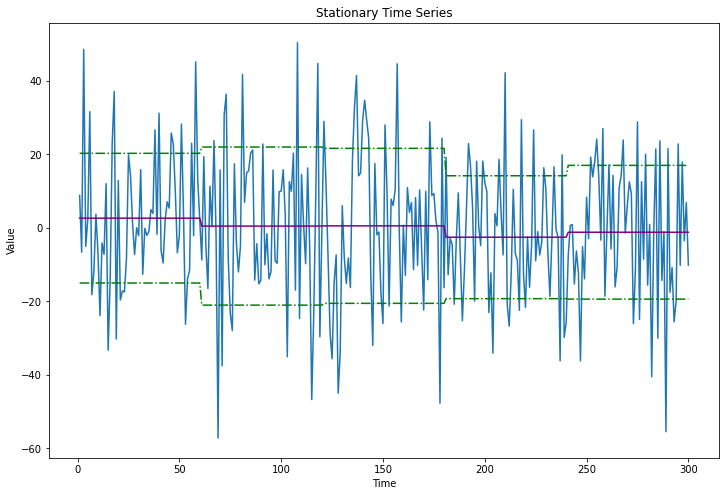

In [18]:
ts_plot_msigma(time,stationary,"Stationary Time Series", nchunks = 5)
plt.savefig("Stationary Time Series - mean and sd")

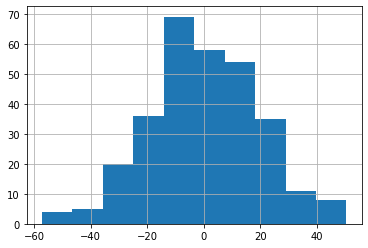

In [19]:
pd.Series(stationary).hist();
plt.savefig("Stationary TS histogram")

In [20]:
# Define normal test wiht significance value alpha
def normaltest_ts(alpha = 0.05, ts = time):
    k2, p_n = normaltest(ts)
    if p_n < alpha:
        print("TS values not normally distributed --> non-stationary \np-value: {:.5f}".format(p_n))
    else:
        print("TS values are normally distributed --> stationary \np-value: {:.5f}".format(p_n))

[Normaltest](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) can confirm if series data is normally distributed (centred around the mean). If p-value < alpha 0.05 can reject the null hypothesis that values normaly distributed.


In [21]:
normaltest_ts(ts = stationary)

TS values are normally distributed --> stationary 
p-value: 0.97119


#### Augmented Dickey-Fuller test for stationarity

[Ref](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)
<br><br>
For more on [stationary TS and mean reversion.](https://www.quantstart.com/articles/Basics-of-Statistical-Mean-Reversion-Testing/)

In [22]:
def adf_test(ts = time, alpha = 0.05):
    adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts)
    if pvalue < alpha:
        print("ADF statistic: {:.2f} \np-value: {:.4f} \nStationary according to ADF alpha = {:.2f}".format(adf, pvalue, alpha))
    else:
        print("ADF statistic: {:.2f} \np-value: {:.4f} \nNon-stationary according to ADF alpha = {:.2f}".format(adf,pvalue,alpha))
    

In [23]:
adf_test(ts = stationary)

ADF statistic: -17.34 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


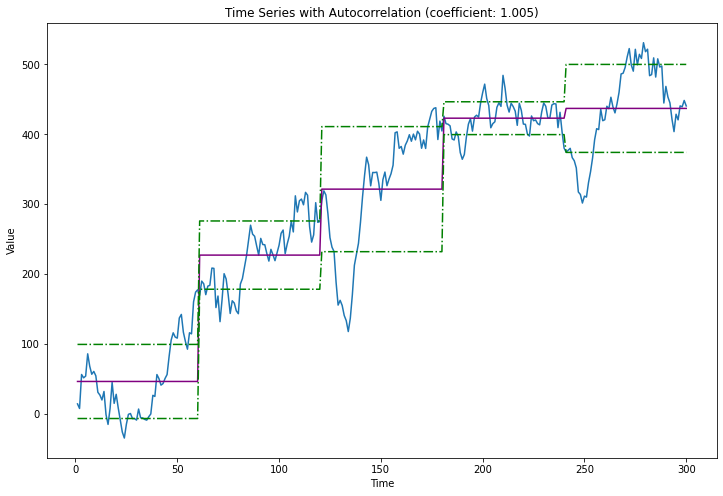

In [24]:
ts_plot_msigma(time,ac_ts,"Time Series with Autocorrelation (coefficient: {})".format(alpha),nchunks=5)
plt.savefig("Additive TS - mean and sd")

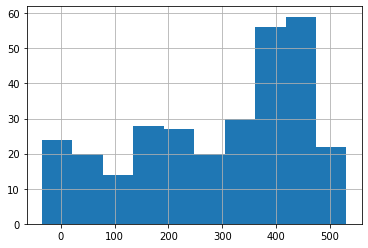

In [25]:
pd.Series(ac_ts).hist();
plt.savefig("Additive TS histogram")

In [26]:
normaltest_ts(ts = ac_ts)

TS values not normally distributed --> non-stationary 
p-value: 0.00000


In [27]:
adf_test(ts = ac_ts)

ADF statistic: -1.59 
p-value: 0.4880 
Non-stationary according to ADF alpha = 0.05


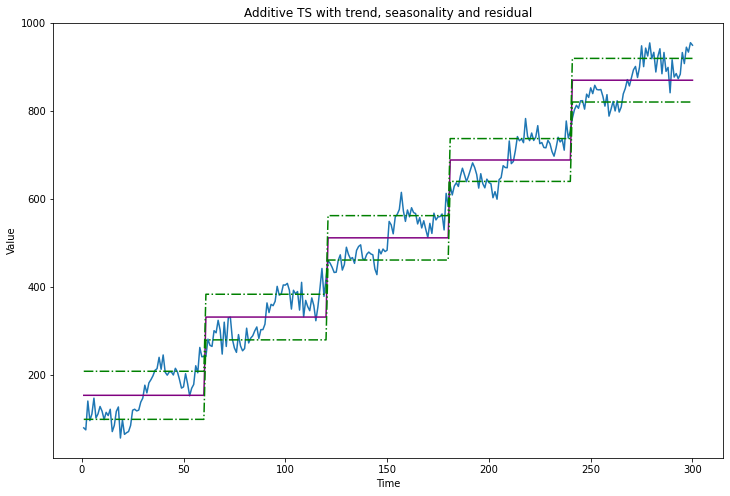

In [28]:
ts_plot_msigma(time,additive_tsr,"Additive TS with trend, seasonality and residual",nchunks =5)

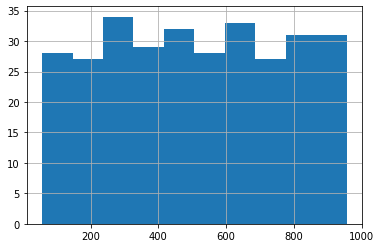

In [29]:
pd.Series(additive_tsr).hist();

In [30]:
normaltest_ts(ts = additive_tsr)

TS values not normally distributed --> non-stationary 
p-value: 0.00000


In [31]:
adf_test(ts = additive_tsr)

ADF statistic: -0.19 
p-value: 0.9392 
Non-stationary according to ADF alpha = 0.05


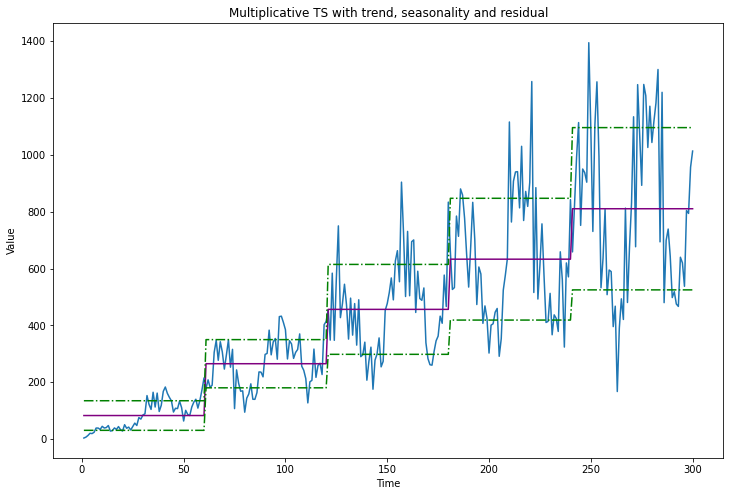

In [32]:
ts_plot_msigma(time,multiplicative_tsr,"Multiplicative TS with trend, seasonality and residual",nchunks =5)

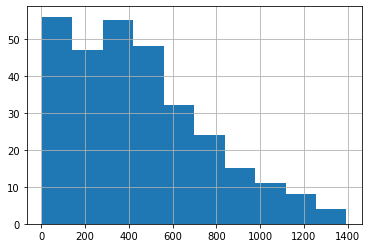

In [33]:
pd.Series(multiplicative_tsr).hist();

In [34]:
normaltest_ts(ts = multiplicative_tsr)

TS values not normally distributed --> non-stationary 
p-value: 0.00001


In [35]:
adf_test(ts = multiplicative_tsr)

ADF statistic: -1.03 
p-value: 0.7405 
Non-stationary according to ADF alpha = 0.05


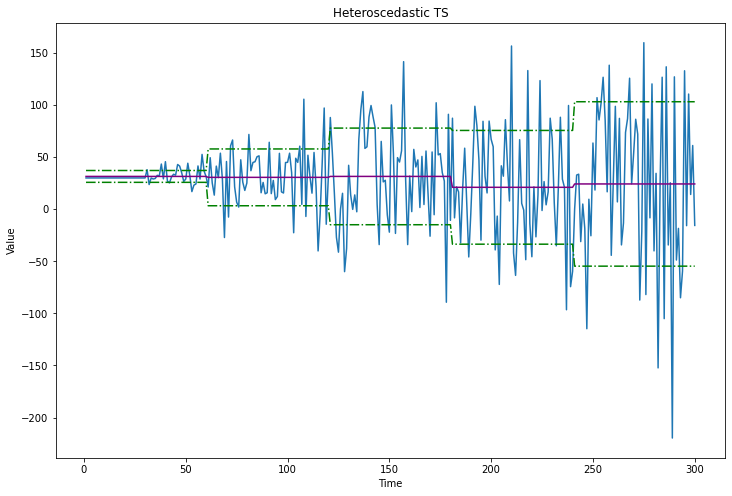

In [36]:
ts_plot_msigma(time,heteroscedastic,"Heteroscedastic TS",nchunks =5)

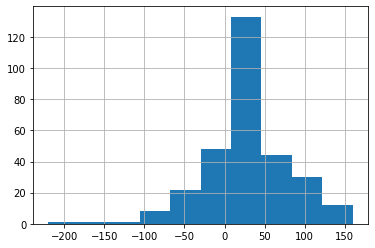

In [37]:
pd.Series(heteroscedastic).hist();

In [38]:
normaltest_ts(ts = heteroscedastic)

TS values not normally distributed --> non-stationary 
p-value: 0.00000


In [39]:
adf_test(ts = heteroscedastic)

ADF statistic: -5.53 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


In [40]:
# ts_plot_msigma(time,seasonal,"Seasonal Time Series", nchunks = 20)

### Transforming non-stationary data to stationary

#### Time series decomposition

Using the [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library TS data with seasonality can be decomposed using seasonal_decompose method.

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose

# the period of the seasonal component equals the number of timepoints divided by the frequency
freq = 10 # this value was used to simulate the additive and multiplicative TS data
period = int(N/freq)

ss_decomposition = seasonal_decompose(x=additive_tsr, model='additive', period=period)
estimated_trend_add = ss_decomposition.trend
estimated_seasonal_add = ss_decomposition.seasonal
estimated_residual_add = ss_decomposition.resid

ss_decomposition = seasonal_decompose(x=additive_tsr, model='multiplicative', period=period)
estimated_trend_mult = ss_decomposition.trend
estimated_seasonal_mult = ss_decomposition.seasonal
estimated_residual_mult = ss_decomposition.resid

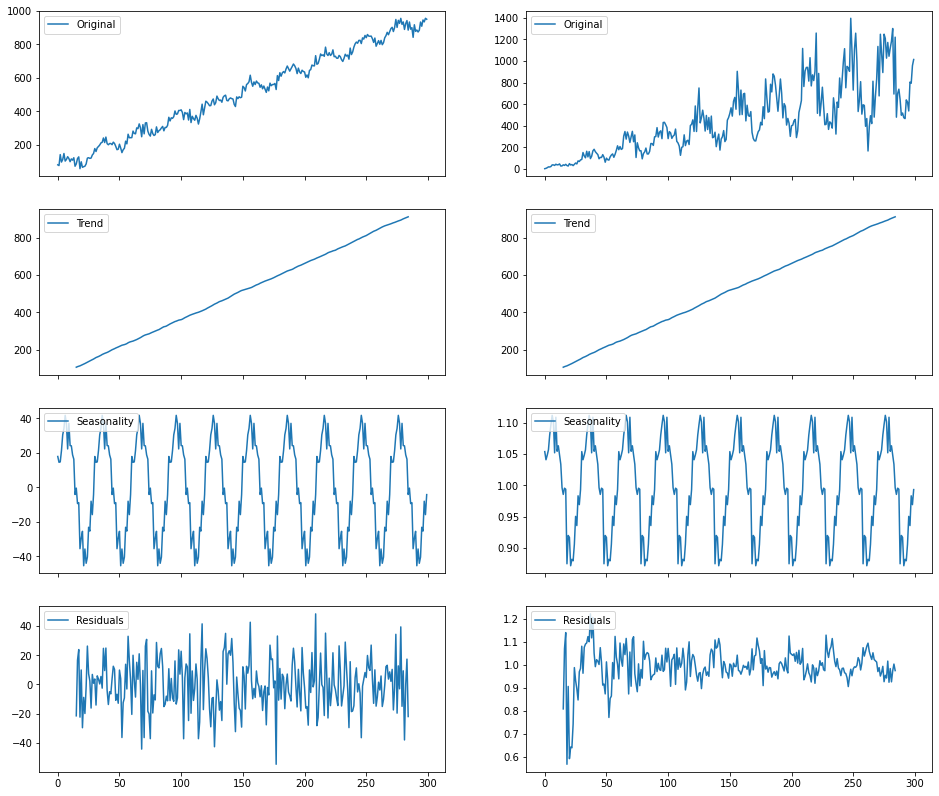

In [42]:
fig, axes = plt.subplots(4, 2, sharex=True, sharey=False)
fig.set_figheight(14)
fig.set_figwidth(16)

axes[0,0].plot(additive_tsr, label='Original')
axes[0,0].legend(loc='upper left');

axes[0,1].plot(multiplicative_tsr, label='Original')
axes[0,1].legend(loc='upper left')

axes[1,0].plot(estimated_trend_add, label='Trend')
axes[1,0].legend(loc='upper left');

axes[1,1].plot(estimated_trend_mult, label='Trend')
axes[1,1].legend(loc='upper left');

axes[2,0].plot(estimated_seasonal_add, label='Seasonality')
axes[2,0].legend(loc='upper left');

axes[2,1].plot(estimated_seasonal_mult, label='Seasonality')
axes[2,1].legend(loc='upper left');

axes[3,0].plot(estimated_residual_add, label='Residuals')
axes[3,0].legend(loc='upper left');

axes[3,1].plot(estimated_residual_mult, label='Residuals')
axes[3,1].legend(loc='upper left');

plt.savefig("Seasonal decomposition")

Do summary stats plot, histogram, normality and AdF tests on residual

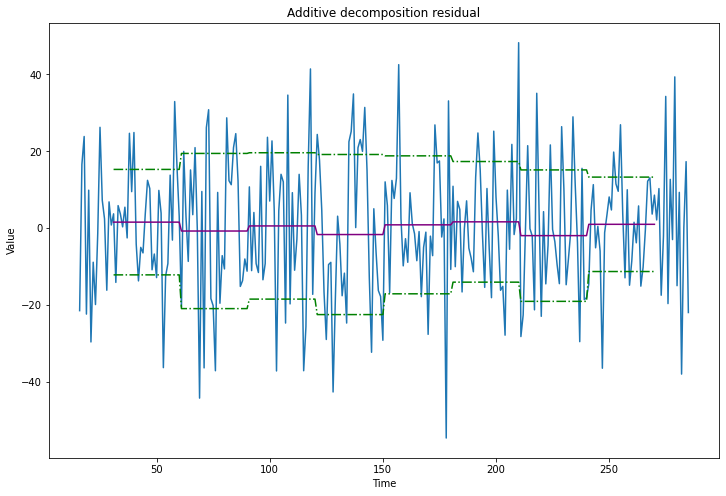

In [43]:
# estimated_residual_add
ts_plot_msigma(time, estimated_residual_add,"Additive decomposition residual",nchunks = 10)
# estimated_residual_mult

<AxesSubplot:>

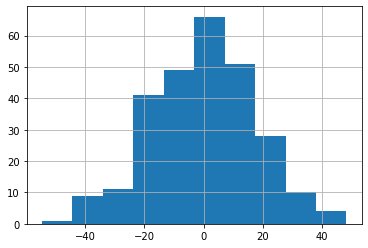

In [44]:
pd.Series(estimated_residual_add).hist()


In [45]:
normaltest_ts(ts = estimated_residual_add[15:-15])

TS values are normally distributed --> stationary 
p-value: 0.88933


In [46]:
adf_test(ts = estimated_residual_add[15:-15])

ADF statistic: -7.88 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


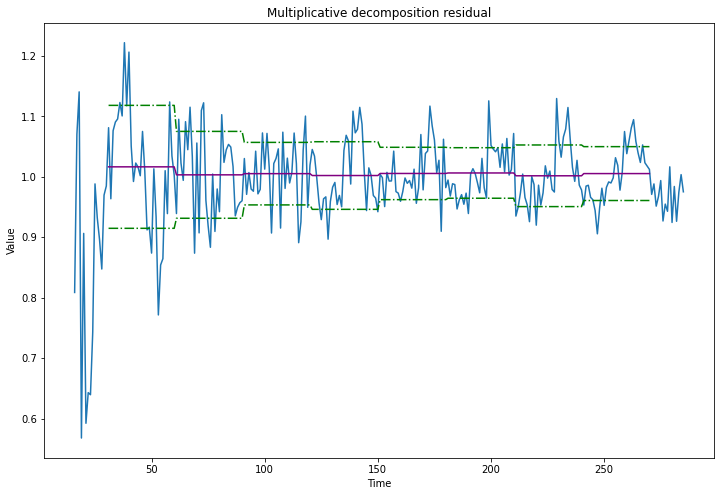

In [47]:
# estimated_residual_add
ts_plot_msigma(time, estimated_residual_mult,"Multiplicative decomposition residual",nchunks = 10)
# estimated_residual_mult


<AxesSubplot:>

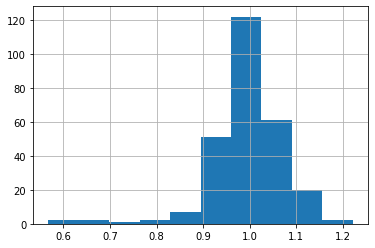

In [48]:
pd.Series(estimated_residual_mult[15:-15]).hist()
#estimated_residual_mult[-15:15]

In [49]:
normaltest_ts(ts = estimated_residual_mult[15:-15])

TS values not normally distributed --> non-stationary 
p-value: 0.00000


In [50]:
adf_test(estimated_residual_mult[15:-15])

ADF statistic: -8.48 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


#### Log transformation of heteroscedastic data

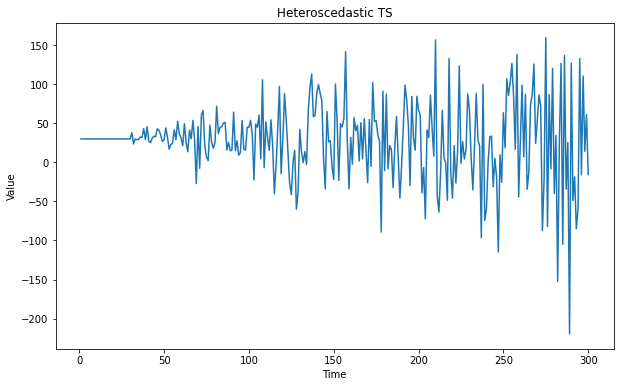

In [51]:
ts_plot(time, heteroscedastic, "Heteroscedastic TS")

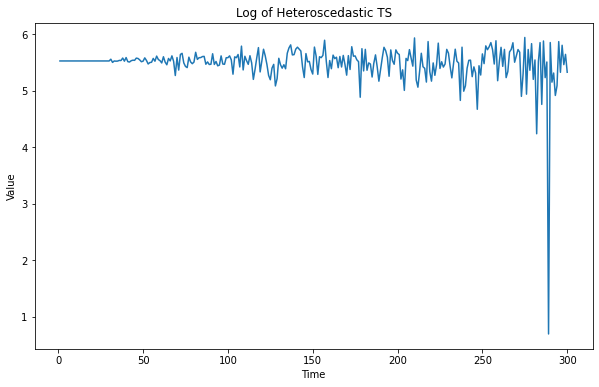

In [52]:
log_hetero = np.log(heteroscedastic - min(heteroscedastic) + 2)
ts_plot(time,log_hetero,"Log of Heteroscedastic TS")

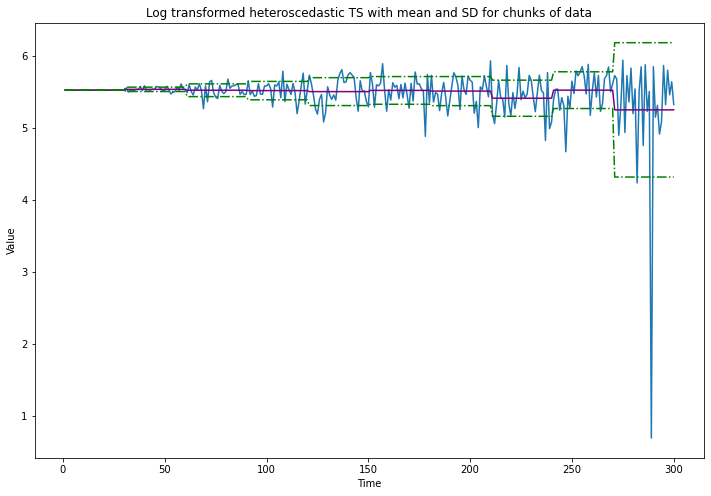

In [53]:
ts_plot_msigma(time, log_hetero,"Log transformed heteroscedastic TS with mean and SD for chunks of data",nchunks = 10)

<AxesSubplot:>

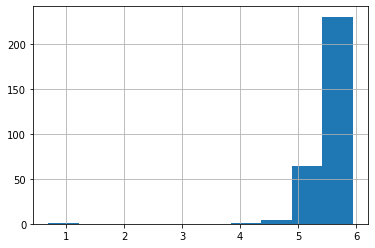

In [54]:
pd.Series(log_hetero).hist()

In [55]:
normaltest_ts(ts = log_hetero)

TS values not normally distributed --> non-stationary 
p-value: 0.00000


In [56]:
adf_test(log_hetero)

ADF statistic: -4.90 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


#### Differencing on autocorrelated data

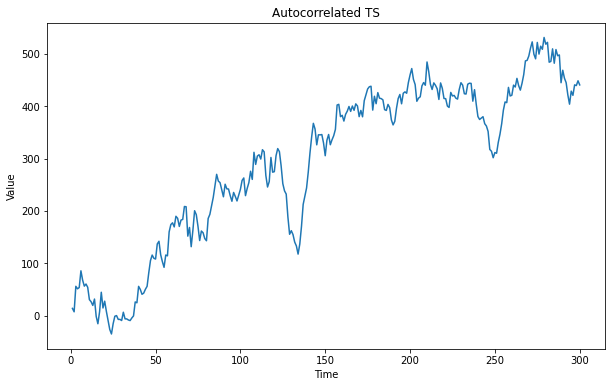

In [57]:
ts_plot(time, ac_ts, "Autocorrelated TS")

In [58]:
diff = ac_ts[:-1]- ac_ts[1:]
lag1 = pd.DataFrame({'original' : ac_ts[:-1],'lag1': ac_ts[1:] ,'diff': diff})
lag1.head()


,original,lag1,diff
0,13.84,7.29,6.55
1,7.29,55.95,-48.66
2,55.95,51.19,4.76
3,51.19,53.64,-2.45
4,53.64,85.56,-31.92


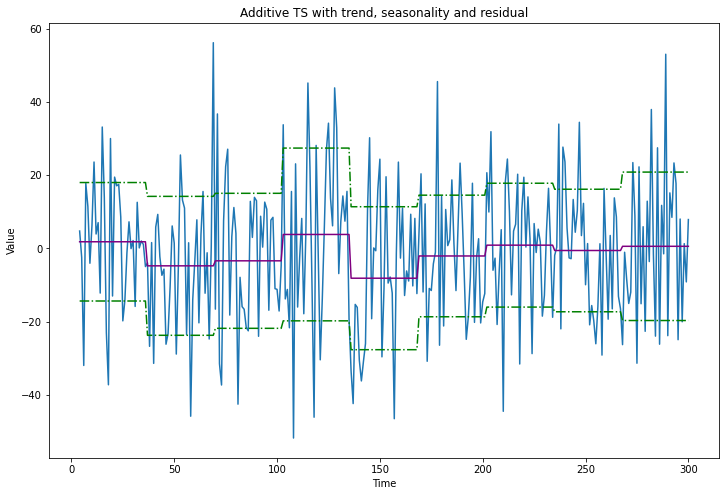

In [59]:
ts_plot_msigma(time[3:], diff[2:],"Additive TS with trend, seasonality and residual",nchunks = 9)

<AxesSubplot:>

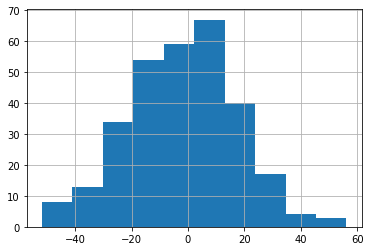

In [60]:
pd.Series(diff).hist()

In [61]:
normaltest_ts(ts = diff)

TS values are normally distributed --> stationary 
p-value: 0.98365


In [62]:
adf_test(ts = diff)

ADF statistic: -17.37 
p-value: 0.0000 
Stationary according to ADF alpha = 0.05


## Measuring model performance

**Mean square error (MSE) metric** is used to measure the performance of the prediction model. <br><br>

The formula for MSE is:  $MSE = \frac{1}{n}\sum_{i=0}^{n} (observed_{i} - predicted_{i})^2$

In [63]:
def mse(observations, predictions):
    '''
    INPUT:
        observations - np array of observed values
        predictions - np array of predicted values
    OUTPUT:
        MSE value
    '''
    # Check argument type
    assert type(observations) == type(np.array([])), "observations input is np array"
    assert type(predictions) == type(np.array([])), "predictions input is np array"
    # check arrays are equal
    assert len(observations) == len(predictions), "Arrays must be of equal length"
    
    # Compute
    mse = np.mean((observations - predictions)**2)
    
    return mse

Moving average function from [here](https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-python-numpy-scipy#14314054). 

In [64]:
def moving_average(observations, window=3, forecast=False):
    '''returns the smoothed version of an array of observations.'''
    cumulative_sum = np.cumsum(observations, dtype=float)
    cumulative_sum[window:] = cumulative_sum[window:] - cumulative_sum[:-window]
    if forecast:
        return np.insert(cumulative_sum[window - 1:] / window, 0, np.zeros(3))
    else:
        return cumulative_sum[window - 1:] / window

Next, generating a residual by subtracting out the moving average from the original ts, and log transforming the reisdual.

9110.034579828474


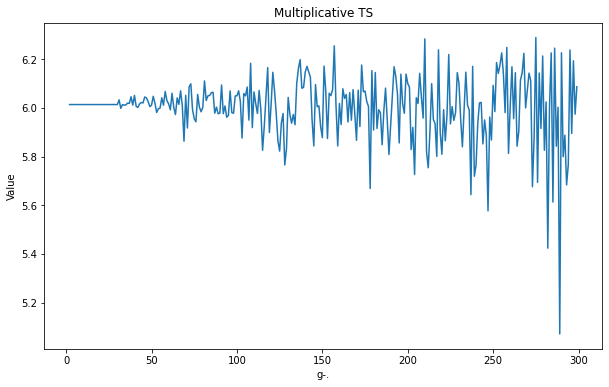

In [65]:
smooth_mult_tsr = moving_average(multiplicative_tsr, window = 3, forecast = False)

#plt.plot(time, multiplicative_tsr, color = "red")
my_resid = multiplicative_tsr[1:-1] - smooth_mult_tsr
#ts_plot(time[1:-1], my_resid, "Multiplicative TS","g-.")
log_resid = np.log(heteroscedastic + 379)
#plt.plot(time[1:-1],log_resid[1:-1])
ts_plot(time[1:-1], log_resid[1:-1], "Multiplicative TS","g-.")
mse_1 = mse(multiplicative_tsr[1:-1],smooth_mult_tsr)
print(mse_1)
#len(smooth_mult_tsr)

### Exponential smoothing


In [66]:
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt # Double exponential smoothing
from statsmodels.tsa.api import ExponentialSmoothing # Triple exp smoothing

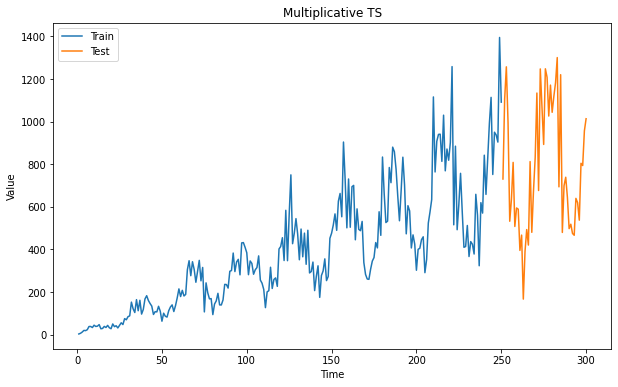

In [67]:
test_size = 50
freq = 10

# Split data into train and test sets
train = multiplicative_tsr[:-test_size]
train_time = time[:-test_size]
test = multiplicative_tsr[-test_size:]
test_time = time[-test_size:]

# Plot train and test sets
ts_plot(train_time,train,"Multiplicative TS", label = "Train")
plt.plot(test_time,test, label ="Test")
plt.legend(loc='upper left')

In [68]:
#import warnings
#from statsmodels.tools.sm_exceptions import ConvergenceWarning
#warnings.simplefilter('ignore', ConvergenceWarning)
# Log transoration of multiplicative process will generate the addtive one
# log(Data) = log(Trend x Seasonal x Random)
model_3e = ExponentialSmoothing(train,damped_trend = True,
                                trend = 'additive',
                                seasonal="additive",
                                seasonal_periods = int(300/freq)).fit(optimized=True)
triple_preds = model_3e.forecast(len(test))
triple_mse = mse(test, triple_preds)
print("Predictions: ", triple_preds)
print("MSE: ", triple_mse)


Predictions:  [1097.843 1067.812 1078.045  984.026 1000.484 1047.067  982.006  970.113
  952.04   917.134  922.219  951.51   950.983  972.72   981.706  994.849
  972.632 1039.713 1060.165 1207.092 1099.324 1130.411 1151.949 1171.309
 1140.915 1217.705 1188.889 1174.723 1195.641 1155.326 1169.028 1138.027
 1147.303 1052.34  1067.868 1113.532 1047.565 1034.78  1015.825  980.05
  984.278 1012.724 1011.362 1032.277 1040.451 1052.794 1029.788 1096.09
 1115.773 1261.942]
MSE:  136214.34599483933


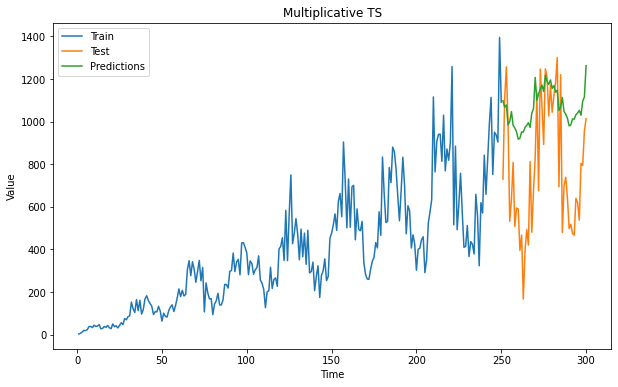

In [69]:
# Plotting train, test and predictions
ts_plot(train_time,train,"Multiplicative TS", label = "Train")
plt.plot(test_time,test, label ="Test")
plt.plot(test_time,triple_preds, label ="Predictions")
plt.legend(loc='upper left')
plt.savefig("Exponential smoothing")

#### Additive TS - exponential smoothing 

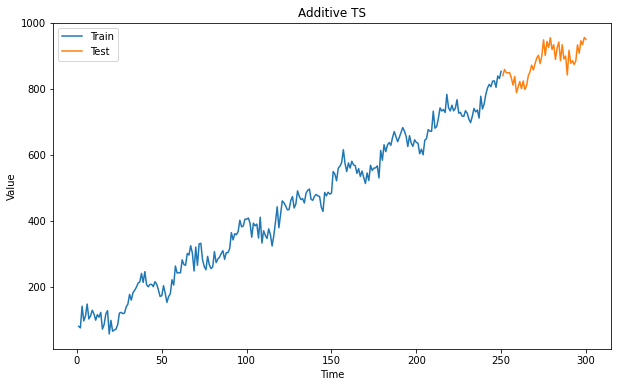

In [70]:
test_size = 50

# Split data into train and test sets
train_a = additive_tsr[:-test_size]
train_time = time[:-test_size]
test_a = additive_tsr[-test_size:]
test_time = time[-test_size:]

# Plot train and test sets
ts_plot(train_time,train_a,"Additive TS", label = "Train")
plt.plot(test_time,test_a, label ="Test")
plt.legend(loc='upper left')

MSE:  429.1714110213057


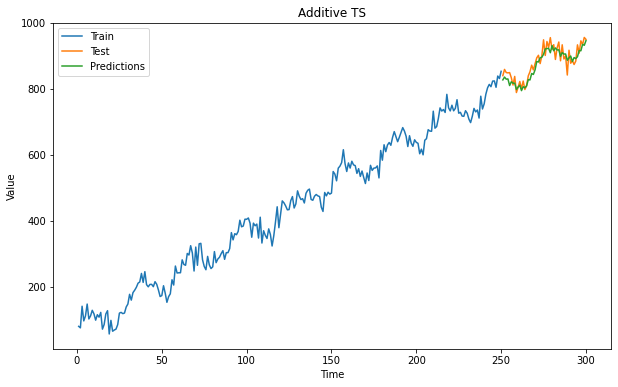

In [71]:
model_3e_a = ExponentialSmoothing(train_a,damped_trend = False,
                                trend = 'additive',
                              seasonal="additive",
                              seasonal_periods = int(300/freq)).fit(optimized=True)
triple_preds_a = model_3e_a.forecast(len(test_a))
triple_mse = mse(test_a, triple_preds_a)
#print("Predictions: ", triple_preds_a)
print("MSE: ", triple_mse)

# Plot
ts_plot(train_time,train_a,"Additive TS", label = "Train")
plt.plot(test_time,test_a, label ="Test")
plt.plot(test_time,triple_preds_a, label ="Predictions")
plt.legend(loc='upper left')
plt.savefig("Exponential smoothing - Additive")

#### Autocorrelation TS with exonential smoothing

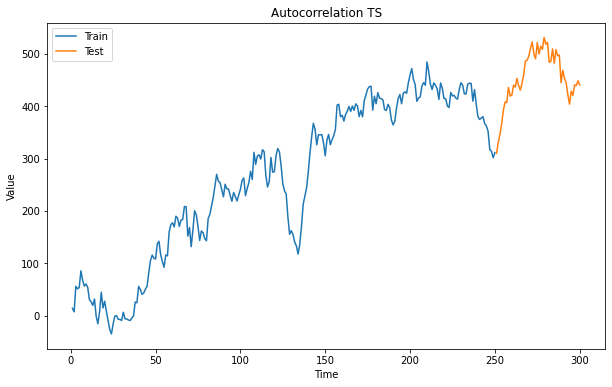

In [72]:
test_size = 50

# Split data into train and test sets
train_ac = ac_ts[:-test_size]
train_time = time[:-test_size]
test_ac = ac_ts[-test_size:]
test_time = time[-test_size:]

# Plot train and test sets
ts_plot(train_time,train_ac,"Autocorrelation TS", label = "Train")
plt.plot(test_time,test_ac, label ="Test")
plt.legend(loc='upper left')

#### Triple exponential smoothing

Triple exp smoothing MSE:  15260.107752253898
Single exp smoothing MSE:  23295.257718419252


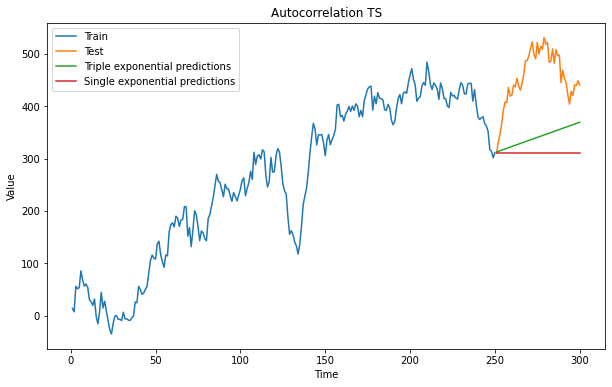

In [73]:
# Triple Exponential smoothing
model_3e_ac = ExponentialSmoothing(train_ac,damped_trend = False,
                                trend = 'additive',
                              seasonal=None,
                              seasonal_periods = None).fit(optimized=True)
triple_preds_ac = model_3e_ac.forecast(len(test_a))
triple_mse = mse(test_ac, triple_preds_ac)
#print("Predictions: ", triple_preds_a)
print("Triple exp smoothing MSE: ", triple_mse)

# Single Exponential smoothing
model_1e_ac = SimpleExpSmoothing(train_ac).fit(optimized=True)
single_preds_ac = model_1e_ac.forecast(len(test_ac))
single_mse = mse(test_ac, single_preds_ac)
#print("Predictions: ", triple_preds_a)
print("Single exp smoothing MSE: ", single_mse)

# Double exponential smoothing - same as triple exp smoothing w/o seasonality
#model_2e_ac = Holt(train_ac).fit(optimized=True)
#double_preds_ac = model_2e_ac.forecast(len(test_ac))
#double_mse = mse(test_ac, double_preds_ac)
#print("Predictions: ", double_preds_ac)
#print("MSE: ", double_mse)

# Plot
ts_plot(train_time,train_ac,"Autocorrelation TS", label = "Train")
plt.plot(test_time,test_ac, label ="Test")
plt.plot(test_time,triple_preds_ac, label ="Triple exponential predictions")
plt.plot(test_time,single_preds_ac, label ="Single exponential predictions")
#plt.plot(test_time,double_preds_ac, label ="Double exponential predictions")
plt.legend(loc='upper left')
plt.savefig("Exp smoothing - Autocorrelation")

## 3. ARIMA 

Auto Regressive Integrated Moving Average (ARIMA) models forecast stationary data that show mean reversion by finding the dependence of the target variable(s) on previously observed values (auto regression) and the dependence on previous error terms.
<br> <br>


In [74]:
# using  statsmodel ARIMA pack
model = ARIMA(ac_ts, order =(1, 0, 0)).fit()
model.params

array([290.766,   0.995, 368.139])

In [75]:
# generate TS using ARIMA model
# np.random.seed(5)
# ar_params = np.array([0.3,0.3])
# ma_params = np.array([0])
# ar = np.r_[1, -ar_params] # add zero-lag and negate, np.r_ is simply making it one array
# ma = np.r_[1, ma_params] # add zero-lag
# y = arma_generate_sample(ar, ma, 100)



Using the [Pmdarima](https://pypi.org/project/pmdarima/) library

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2182.512, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2184.201, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2184.199, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2181.473, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2186.199, Time=0.07 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.270 seconds


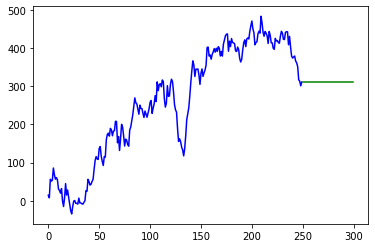

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1089.736
Date:                Thu, 17 Nov 2022   AIC                           2181.473
Time:                        09:55:56   BIC                           2184.990
Sample:                             0   HQIC                          2182.889
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       370.5709     33.034     11.218      0.000     305.825     435.317
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 0.31
Prob(Q):                              0.57   Pr

In [76]:
# Load/split the autocorrelation data
y = ac_ts
train_size = 250
train, test = pm.model_selection.train_test_split(y, train_size=train_size)

# Fit your model
model = pm.auto_arima(train, start_p=0, start_q=0,test='adf',m=300,seasonal=False,start_P=0, D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.show()

print(model.summary())

# grid search to find parameter

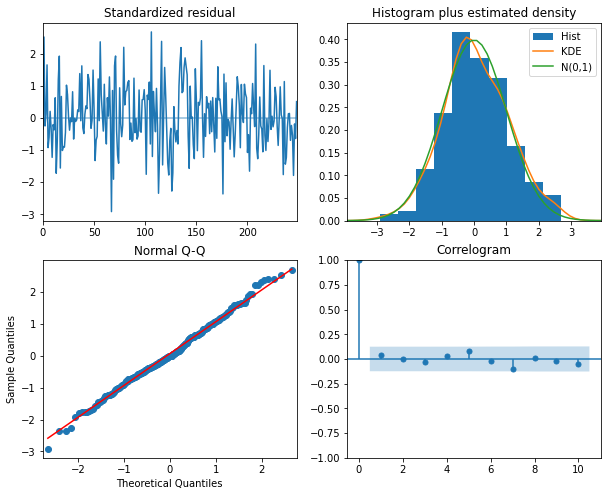

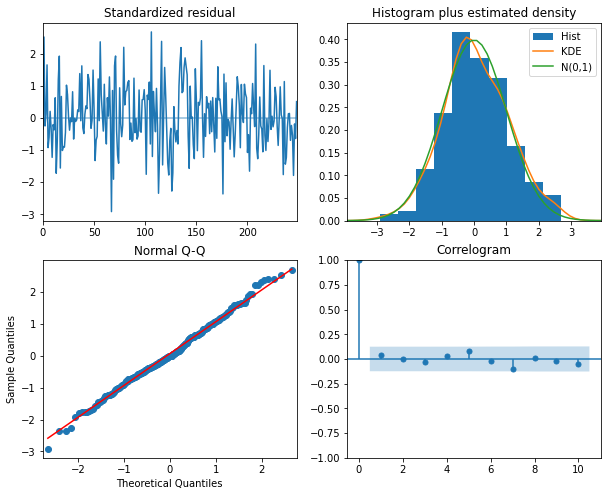

In [77]:
model.plot_diagnostics(figsize=(10,8))

In [78]:
'''
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
'''

"\n# Forecast\nn_periods = 24\nfc, confint = model.predict(n_periods=n_periods, return_conf_int=True)\nindex_of_fc = np.arange(len(df.value), len(df.value)+n_periods)\n\n# make series for plotting purpose\nfc_series = pd.Series(fc, index=index_of_fc)\nlower_series = pd.Series(confint[:, 0], index=index_of_fc)\nupper_series = pd.Series(confint[:, 1], index=index_of_fc)\n\n# Plot\nplt.plot(df.value)\nplt.plot(fc_series, color='darkgreen')\nplt.fill_between(lower_series.index, \n                 lower_series, \n                 upper_series, \n                 color='k', alpha=.15)\n"

## References
The open access version of the course guided my approach to TS synthesis and characterisation, with a great overview of TS theory and forecasting methods, with implementation examples. [Specialized Models: Time Series and Survival Analysis, Coursera](https://www.coursera.org/learn/time-series-survival-analysis) [accessed 25 October 2022]

#### Synthetic Time Series and stationarity
* [Time Series Analysis: The Basics](https://www.abs.gov.au/websitedbs/D3310114.nsf/home/Time+Series+Analysis:+The+Basics#HOW%20DO%20I%20KNOW%20WHICH%20DECOMPOSITION) [accessed 26 October 2022]
* [A Complete Tutorial on Time Series Modeling in R](https://www.analyticsvidhya.com/blog/2015/12/complete-tutorial-time-series-modeling/) [accessed 26 October 2022]
* [An Introduction to Non-Stationary Processes](https://www.investopedia.com/articles/trading/07/stationary.asp) [accessed 26 October 2022]
<br><br>

#### Time Series Preprocessing
<br><br>

#### Exponential Smoothing
* [Chapter 7 Exponential Smoothing](https://otexts.com/fpp2/expsmooth.html) | Forecasting: Principles and Practice (2nd Ed) [accessed 25 October 2022]. 
* [How to Grid Search Triple Exponential Smoothing for Time Series Forecasting in Python](https://machinelearningmastery.com/how-to-grid-search-triple-exponential-smoothing-for-time-series-forecasting-in-python/) [accessed 26 October 2022]
* [A Gentle Introduction to Exponential Smoothing for Time Series Forecasting in Python](https://machinelearningmastery.com/exponential-smoothing-for-time-series-forecasting-in-python/) [accessed 26 October 2022]
<br><br>

#### AR / MA / (S)ARIMA
* [Chapter 8 ARIMA Models](https://otexts.com/fpp2/arima.html) | Forecasting: Principles and Practice (2nd Ed) [accessed 25 October 2022].
* [Identifying the Order of Differencing in ARIMA Models](https://people.duke.edu/~rnau/411arim2.htm) [accessed 25 October 2022]
* [Efficient Time-Series Analysis Using Python’s Pmdarima Library](https://towardsdatascience.com/efficient-time-series-using-pythons-pmdarima-library-f6825407b7f0) [accessed 26 October 2022]
* [ARIMA Model – Complete Guide to Time Series Forecasting in Python](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/)
* [Python | ARIMA Model for Time Series Forecasting](https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/)
* [ARIMA Model for Time Series Forecasting](https://www.kaggle.com/code/prashant111/arima-model-for-time-series-forecasting)
* [Moving Average (MA) process: numerical intuition](https://stats.stackexchange.com/questions/164824/moving-average-ma-process-numerical-intuition)
<br><br>

#### Machine Learning
* [LSTM for Time Series Forecasting](https://www.kaggle.com/code/smrime/lstm-for-time-series-forecasting) notebook on Kaggle
* [LSTM in ML](https://thecleverprogrammer.com/2020/08/11/lstm-in-machine-learning/) article
* [Time Series Forecasting Using Xboost](https://www.kaggle.com/code/smrime/time-series-forecast-using-xgboost) notebook on Kaggle
* [Time Series](https://www.kaggle.com/learn/time-series) course on Kaggle
* [Facebook Prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api) and the research paper [Forecasting at Scale](https://peerj.com/preprints/3190/#)
<br><br>